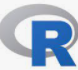 you normal? 

There is an inbalance between R and Python 🐍 notebooks in this competition, so I will try to reduce it 🧐.

## Main objective 🎯
The **main objective** is to predict whether a participant is:

1.   Pre-Alzheimer’s
2.   Post-Alzheimer’s
3.   Normal

## The Challenges 💪

1) The **first challenge** come from **overbalance** ⚖️ of "Normal" class. Few observations with Alzheimer, especially in early warning (Pre-Alzheimer), so the model will have difficulties to predict this class. We will see that probabilities are low, any above 25%!

2) The **second challenge** come from "Normal" which means "**Not having Alzheimer**" 🤔, which could hide healthy person or diseases like Parkinson, Lewy-body, Pick's, or vascular dementia, with some common pathologies with Alzheimer. 

The model will have difficulties to understand why a participant is "normal", whereas his Clock Drawing has only 2 digits and 1 hand! If all strange clocks were from Alzheimer' patients ... But combined with overbalance of "Not Alzheimer" class, the model doesn't take risk to predict "Alzheimer", it's safer to kept "Not Alzheimer" with a high probability ..

3) The **third challenge** come from different **classes distributions** 📈 between train dataset (95% of "Not Alzheimer") and test dataset (only 75%). Predictive models, like xgboost, try to replicate the training distribution, leading to poor predictions on the test dataset. Hopefully, it exists several ways (undersampling, weightings, ...) to adjust it during training. But it lets us ask:

- what is the distribution of the leaderboard dataset? 
- where do observations come from? Maybe the test dataset is from hospital' patients, and the training one from a different population? Maybe training contains synthetic points to increase its size? Knowing the source of observations is something very important before building a predictive model. 

4) The **fourth challenge** come from **image detection** 📷. We don't know its accuracy, but on the description PDF, one digit 12 is detected as digits 1 and 2. It means that some elements of the clock could be missed or misinterpreted. Could we fix some mistakes? 

🏁 These challenges in mind, we will setup the notebook (librairies, datasets) and build an xgboost model with 5-folds cross-validation. Some feature engineering are done, but nothing extraordinary. Playing with weightings and setseeds can help to briefly **overfit** the leaderboard dataset (**0.606**) and gain some ranks 🏆, but there is no guarantee of capturing a general robust signal. 

# Setup AIcrowd Utilities 🛠

In [ ]:
cat(system('curl -sL https://gitlab.aicrowd.com/snippets/34123/raw > aicrowd.R', intern=TRUE), sep='\n')
cat(system('pip3 install -q -U aicrowd-cli', intern=TRUE), sep='\n')
source("aicrowd.R")

In [ ]:
# Paths
AICROWD_DATASET_PATH = Sys.getenv("DATASET_PATH", "/ds_shared_drive/validation.csv")
AICROWD_PREDICTIONS_PATH = Sys.getenv("PREDICTIONS_PATH", "predictions.csv")
AICROWD_ASSETS_DIR = "assets"

# Install packages 📚

Most of the packages are already available, but we have to add the **xgboost** one.

In [ ]:
cat(system('conda install --quiet --yes -c conda-forge r-xgboost', intern=TRUE), sep='\n')

Solving environment: ...working... done

# All requested packages already installed.



# Define preprocessing code 🚧

In [ ]:
library(xgboost)
library(tidyverse)

In [ ]:
preprocess_data <- function(data){
    
    data_clean <- data %>%
        select(-row_id) %>%
        mutate(
            count_NA__            = apply(data, 1, function(x) sum(is.na(x))),
            mean_dist_cen__       = apply(select(data, matches('dist.from.cen')), 1, function(x) mean(x, na.rm = TRUE)),
            mean_euc_cen__        = apply(select(data, matches('euc_dist')), 1, function(x) mean(x, na.rm = TRUE)),
            mean_digit_area__     = apply(select(data, matches('area_digit')), 1, function(x) mean(x, na.rm = TRUE)),                                                          
            mean_area_perc__      = apply(select(data, matches('area_perc')), 1, function(x) sd(x, na.rm = TRUE)),                              
                                                                               
            ratio_dist_3_9__      = ifelse(X9.dist.from.cen == 0, 0, X3.dist.from.cen / X9.dist.from.cen),
            ratio_dist_6_12__     = ifelse(X12.dist.from.cen == 0, 0, X6.dist.from.cen / X12.dist.from.cen),
            ratio_hands_Xi__        = case_when(
                !is.na(minute_hand_length) ~ minute_hand_length / mean_dist_cen__,
                !is.na(single_hand_length) ~ single_hand_length / mean_dist_cen__,
            ),
                                          
            ratio_minor_major__   = double_major / pmax(10, double_minor),  
            vertical_ratio__      = vertical_dist / double_major,                               
            horiz_ratio__         = horizontal_dist / pmax(50, double_minor),                                                             
            hour_pointing_near2__ = 1 * (hour_pointing_digit %in% c(1:3)),                         
            angle_perpendicular__ = abs(angle_between_hands - 90),

            random__              = runif(nrow(data), 0, 1)
                                          
        ) %>%
        select(-intersection_pos_rel_centre, -actual_hour_digit, -actual_minute_digit,
               -starts_with('missing_digit'), -number_of_hands, -hand_count_dummy, -centre_dot_detect, -other_error, -pred_tremor, 
               -sequence_flag_cw, -eleven_ten_error, -hor_count, -vert_count, -clockhand_diff, -variance_area,
               -between_digits_angle_ccw_sum, -between_digits_angle_cw_sum, -between_axis_digits_angle_sum
        )                                  
                                         
    return(data_clean) 
}

# Training phase ⚙️

## Load data

In [ ]:
training_data <- read.csv("/ds_shared_drive/train.csv")
table(training_data$diagnosis)


        normal post_alzheimer  pre_alzheimer 
         31208           1149            420 

## Explore data 🔎

In this section, we focus on some specific clocks. 

*  when we look at **"perfect clocks"**, meaning clocks with all digits (or almost) and the two hands pointing in the right direction, there are still some (but very few, 34 out of 10,000) Alzheimers' patient.

--> Could we found other general ways to identify them? Or are there just Alzheimer' patients that the Drawing Clock Test can't capture?


In [ ]:
training_data %>%
    mutate(perfect_clock = 1 * (number_of_digits > 10 & hand_count_dummy == 2 & hour_pointing_digit == 11 & minute_pointing_digit == 2)) %>%
    count(perfect_clock, diagnosis) %>%
    pivot_wider(names_from = 'diagnosis', values_from = 'n')

perfect_clock normal post_alzheimer pre_alzheimer
1  0            20164  1043           374          
2  1            10263    21            13          
3 NA              781    85            33

*  when we look at **"poor clocks"**, meaning clocks with very few digits, or without 2 hands, there are still Not Alzheimer' patients. 

--> are they patients with a cognitive disease but not Alzheimer, so consider as "Normal" in our case?

In [ ]:
training_data %>%
    mutate(poor_clock = 1 * (number_of_digits < 4 | hand_count_dummy < 2)) %>%
    count(poor_clock, diagnosis) %>%
    pivot_wider(names_from = 'diagnosis', values_from = 'n')

poor_clock normal post_alzheimer pre_alzheimer
1  0         22454  258            122          
2  1          7332  623            207          
3 NA          1422  268             91

## Clean data 🧹

We define **weightings** (in order to bring our class distribution closer than the ones of test and leaderboard datasets). 

And we also apply the **preprocess function** define earlier, to create some extra features and remove useless ones.

In [ ]:
training_clean <- training_data %>%
    mutate(
        diagnosis  = as.numeric(factor(diagnosis)) - 1,
        weighting  = case_when(
            diagnosis  == 1  ~ 1,
            diagnosis  == 2  ~ .75,
            TRUE ~             .10
        )
    ) %>%
    preprocess_data()

Here is the new class distribution:

In [ ]:
training_clean %>%
    group_by(diagnosis) %>%
    summarise(expo = n(), expo_w = sum(weighting)) %>%
    mutate(prop = expo / sum(expo), prop_w = expo_w / sum(expo_w))

diagnosis expo  expo_w    prop       prop_w    
1 0         31208 22310.779 0.95213107 0.68068400
2 1          1149  8214.267 0.03505507 0.25061071
3 2           420  2251.953 0.01281386 0.06870529

## Build model 🏋️

In [ ]:
xgb_clean <- training_clean
xgb_vars <- xgb_clean %>%
    select(-diagnosis, -weighting) %>%
    colnames()

# number of features
length(xgb_vars)

[1] 104

In [ ]:
#summary(training_clean)

In [ ]:
xgb_train <- xgb.DMatrix(
    data   = xgb_clean[, xgb_vars] %>% as.matrix(),
    label  = xgb_clean$diagnosis,
    weight = xgb_clean$weighting 
)

Here we define the parameters of our xgboost approach:


*   **booster**: we want to build trees (default parameter) and not regression, as the naive classifier of xgboost.

*  **tree_method** = 'hist' is a way to build tree faster.

* **eta** is the learning rate, which has to be low to prevent overfitting, but not to low, to let time to the model the learn correctly. It has to be combined with the **nrounds**, the number of iterations.

* **max_depth** is the maximum depth of each tree. Same concept as the learning rate, deeper, you will overfitting, not enough deeper and your model will not learn all he can.

* **min_child_weight** again help to prevent overfitting, by adding constraints to the final leaves creation.

* **subsample** and **colsample** are just here to add some random in the observations and features available at each iteration, it will also help to prevent overfitting and force the model to explore all possibilities.



In [ ]:
xgb_param <- list(
    nthread          = 8,
    booster          = 'gbtree',
    tree_method      = 'hist',
    eta              = 0.02,
    max_depth        = 6, 
    min_child_weight = 5, 
    subsample        = .95,
    colsample_bytree = .95,
    objective        = 'multi:softprob',
    eval_metric      = 'mlogloss',
    num_class        = 3
)

set.seed(20210510)

xgb_cv <- xgb.cv(
    data    = xgb_train,
    params  = xgb_param,
    nrounds = 500,
    nfold   = 5,
    print_every_n        = 20,
    early_stopping_round = 40
)
print(xgb_cv$best_iteration)

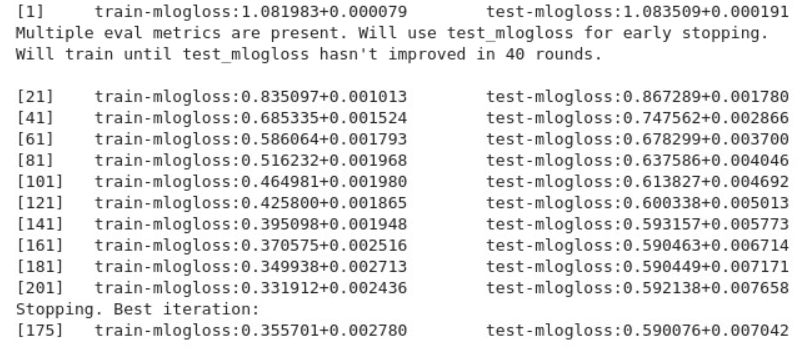

In [ ]:
xgb_mod <- xgb.train(
    data          = xgb_train,
    params        = xgb_param,
    nround        = xgb_cv$best_iteration,
    watchlist     = list(train = xgb_train, wlist = xgb_train), 
    print_every_n = 25
)

## Variable importance 🥇

In [ ]:
xgb_imp <- xgb.importance(model = xgb_mod)
head(xgb_imp, 10)

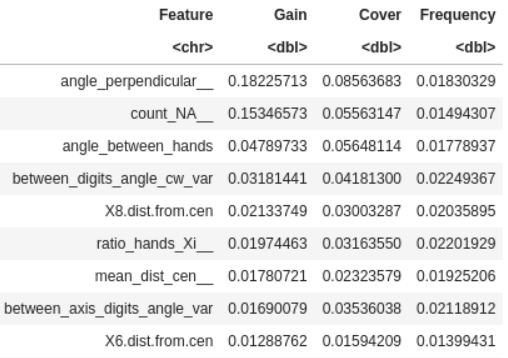

## Random 🎲

I added a **random variable** in the training, in order to detect which variables are explaining noises and not robust signal. In general, I remove all the variables with score/rank under the random one. As their usage by the model is very low, results are very similar (in general, a little lower).

<br />

Here, the rank of the random variable is quite high: **39** !

It means that a lot of variables should be removed ... ✂️

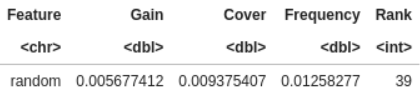

## Performances 🥇

In [ ]:
library(MLmetrics)

In [ ]:
valid_data = read.csv("/ds_shared_drive/validation.csv") %>%
    left_join(read.csv("/ds_shared_drive/validation_ground_truth.csv"), by = 'row_id') %>%
    preprocess_data()

In [ ]:
xgb_probs <- predict(xgb_mod, xgb.DMatrix(valid_data[, xgb_vars] %>% as.matrix()), reshape = TRUE)
MultiLogLoss(xgb_probs, valid_data$diagnosis)
# 0.5719

## Save your trained model 💾

In [ ]:
saveRDS(xgb_vars, file.path(AICROWD_ASSETS_DIR, 'myxgb_vars.RDS'))
saveRDS(xgb_mod, file.path(AICROWD_ASSETS_DIR, 'myxgb_mod.RDS'))

# Prediction phase 🔮

In [ ]:
mymodel_vars <- readRDS(file.path(AICROWD_ASSETS_DIR, 'myxgb_vars.RDS'))
myXGB_model <- readRDS(file.path(AICROWD_ASSETS_DIR, 'myxgb_mod.RDS'))

## Load test data

In [ ]:
test_data  <- read.csv(AICROWD_DATASET_PATH)
test_clean <- preprocess_data(test_data)

## Generate predictions

In [ ]:
sum(!mymodel_vars %in% colnames(test_clean))
xgb_test <- xgb.DMatrix(test_clean[, mymodel_vars] %>% as.matrix())

In [ ]:
predictions <- data.frame(row_id = test_data$row_id) %>%
    cbind(predict(myXGB_model, xgb_test, reshape = TRUE)) %>%
    rename(
        normal_diagnosis_probability         = '1',
        post_alzheimer_diagnosis_probability = '2',
        pre_alzheimer_diagnosis_probability  = '3'
    )

head(predictions)

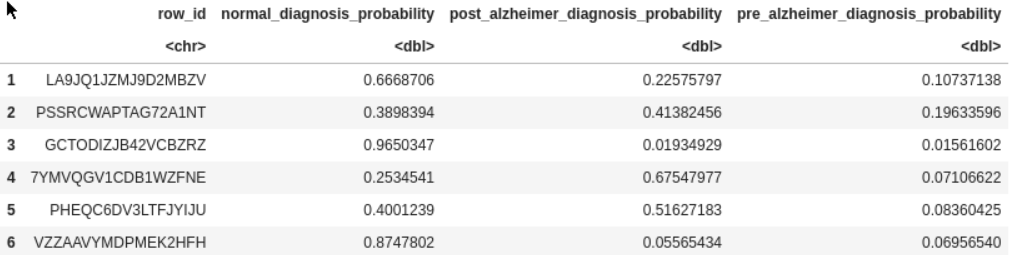

## Save predictions 📨

In [ ]:
write.csv(predictions, AICROWD_PREDICTIONS_PATH, row.names=FALSE)

# Submit to AIcrowd 🚀

**NOTE: PLEASE SAVE THE NOTEBOOK BEFORE SUBMITTING IT (Ctrl + S)**

In [ ]:
aicrowd_login(AICROWD_API_KEY)
aicrowd_submit(AICROWD_ASSETS_DIR, "addi-alzheimers-detection-challenge", dataset_dir = AICROWD_DATASET_PATH)